In [25]:
import xarray as xr
import numpy as np
import os 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import h5py
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter
from matplotlib.path import Path
from datetime import datetime
%matplotlib inline

In [3]:
# Open pre-processed velocity field (August 2007) and check dimensions 
os.chdir('/data/SOSE/SOSE/SO24/RUN_BATHY2/OUTPUT')
UV_field = xr.open_dataset('UVVEL_SO50_2007_AugAvg.nc')
UV_field

<xarray.Dataset> Size: 40GB
Dimensions:  (lon: 8640, lat: 2541, depth: 225, date: 1)
Coordinates:
  * date     (date) float32 4B 1.356e+06
  * lon      (lon) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
  * lat      (lat) float32 10kB -85.5 -85.49 -85.48 ... -50.07 -50.04 -50.01
  * depth    (depth) float32 900B -0.7 -2.117 -3.57 ... -5.879e+03 -5.929e+03
Data variables:
    XG       (lon) float32 35kB ...
    YG       (lat) float32 10kB ...
    RF       (depth) float32 900B ...
    UVEL     (date, depth, lat, lon) float32 20GB ...
    VVEL     (date, depth, lat, lon) float32 20GB ...

In [4]:
# Open grid data and find variables to use for bathymetry 

os.chdir('/data/SOSE/SOSE/SO24/RUN_BATHY2/GRID')

def summarize_mat_hdf5(path):
    with h5py.File(path, "r") as f:
        def walk(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"{name:40s} DATASET  shape={obj.shape}  dtype={obj.dtype}")
            else:
                print(f"{name:40s} GROUP")
        f.visititems(walk)

summarize_mat_hdf5("grid.mat")


DRC                                      DATASET  shape=(1, 226)  dtype=float32
DRF                                      DATASET  shape=(1, 225)  dtype=float32
DXC                                      DATASET  shape=(3456, 8640)  dtype=float32
DXG                                      DATASET  shape=(3456, 8640)  dtype=float32
DYC                                      DATASET  shape=(3456, 8640)  dtype=float32
DYG                                      DATASET  shape=(3456, 8640)  dtype=float32
Depth                                    DATASET  shape=(3456, 8640)  dtype=float32
RAS                                      DATASET  shape=(3456, 8640)  dtype=float32
RAW                                      DATASET  shape=(3456, 8640)  dtype=float32
RC                                       DATASET  shape=(1, 225)  dtype=float32
RF                                       DATASET  shape=(1, 226)  dtype=float32
XC                                       DATASET  shape=(3456, 8640)  dtype=float32
XG      

In [5]:
# Build xarray data array for bathymetry data. 

mat_path = "grid.mat"

with h5py.File(mat_path, "r") as f:
    x = f["x"][()].squeeze()
    if x.ndim == 2:  # (1, 8640) -> (8640,)
        x = x[0, :]
    y = f["y"][()].squeeze()
    if y.ndim == 2:  # (3456, 1) -> (3456,)
        y = y[:, 0]

    depth = f["Depth"][()]  # (3456, 8640)

bathym = xr.DataArray(
    depth,
    dims=("lat", "lon"),            # y=lat, x=lon
    coords={"lat": y, "lon": x},
    name="Depth",
)
print(bathym)

<xarray.DataArray 'Depth' (lat: 3456, lon: 8640)> Size: 119MB
array([[   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       ...,
       [4718.78, 4702.5 , 4718.78, ..., 4718.78, 4718.78, 4721.  ],
       [4718.78, 4702.5 , 4718.78, ..., 4718.78, 4718.78, 4721.  ],
       [4718.78, 4702.5 , 4718.78, ..., 4718.78, 4718.78, 4721.  ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 14kB -85.5 -85.49 -85.48 ... -0.7923 -0.7089 -0.6256
  * lon      (lon) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0


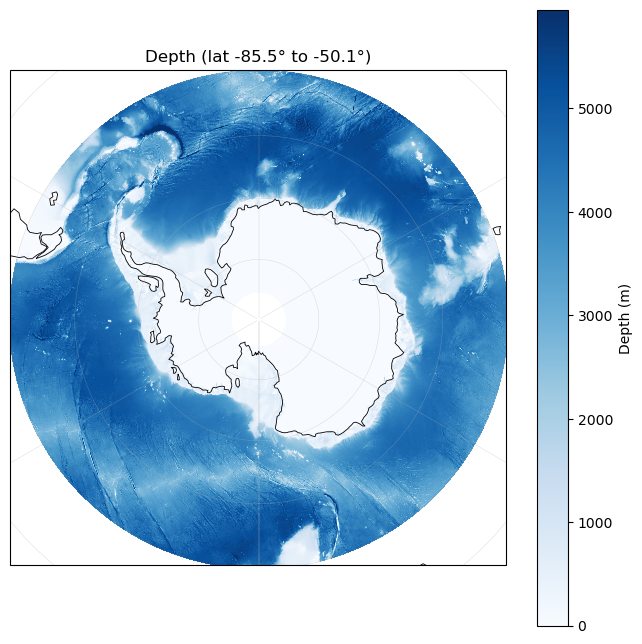

In [6]:
# Plot bathymetry 

# 1) subset latitude
bathym_sub = bathym.sel(lat=slice(-85.5, -50.0))

# (optional) if your lon runs 0..360 and includes 360 exactly, drop the duplicate seam:
if np.isclose(float(bathym_sub.lon[-1]) - float(bathym_sub.lon[0]), 360.0):
    bathym_sub = bathym_sub.isel(lon=slice(0, -1))

# 2) plot on polar stereographic
proj_data = ccrs.PlateCarree()
proj_map  = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj_map)

# extent: use your lon range (likely 0..360) and lats -90..-50
lon_min = float(bathym_sub.lon.min())
lon_max = float(bathym_sub.lon.max())
ax.set_extent([lon_min, lon_max, -90, -50], crs=proj_data)

# draw the field
# 'Blues' goes from light to dark as depth increases
pcm = bathym_sub.plot.pcolormesh(
    ax=ax,
    transform=proj_data,
    cmap="Blues",
    add_colorbar=True,
    add_labels=False,
    cbar_kwargs={"label": "Depth (m)"},
)

# optional map extras
try:
    ax.coastlines(resolution="110m", linewidth=0.6)
except Exception:
    pass  # skip if cartopy can't fetch coastlines

ax.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5)
ax.set_title("Depth (lat -85.5° to -50.1°)")

plt.show()

In [7]:
# check if bathymetry and velocity coordinates match 

print("UV    size/min/max:", UV_field.lat.size, float(UV_field.lat.min()), float(UV_field.lat.max()))
print("BATHY size/min/max:", bathym_sub.lat.size, float(bathym_sub.lat.min()), float(bathym_sub.lat.max()))

UV    size/min/max: 2541 -85.4955062866211 -50.014095306396484
BATHY size/min/max: 2541 -85.49552917480469 -50.01443099975586


In [8]:
# average velocity field over 0-500m depth and subset to depths < 2500 M

UVEL = UV_field.UVEL
VVEL = UV_field.VVEL

# --- 1) Put bathymetry on the VVEL/UVEL grid and build shelf mask (< 2500 m) ---
bathym_on_uv = bathym_sub.interp(lat=VVEL.lat, lon=VVEL.lon, method="nearest")
shelf_mask   = np.abs(bathym_on_uv) < 2500  # True over shelf

# --- 2) Thickness weights for the upper 0–500 m from irregular depth coordinates ---
z = VVEL['depth'].values  # 1D array, negative downward (e.g., -0.7, -2.1, ..., -5900)
edges = np.empty(z.size + 1)
edges[1:-1] = 0.5 * (z[:-1] + z[1:])   # midpoints between levels
edges[0]    = 0.0                      # sea surface
edges[-1]   = z[-1] - (edges[-2] - z[-1])  # extend last interval (won't matter above -500)

# overlap of each layer with the target slab [-500, 0]
top_clip = np.minimum(0.0,   edges[:-1])
bot_clip = np.maximum(-500., edges[ 1:])
thick    = np.maximum(0.0, top_clip - bot_clip)  # positive thickness per level within slab

w = xr.DataArray(thick, coords={'depth': VVEL.depth}, dims=('depth',))

# --- 3) Weighted mean over depth (broadcasts w to all other dims) ---
def upper500_wmean(da, w):
    num = (da * w).sum('depth', skipna=True)
    den = w.sum('depth')
    return num / den

U_0_500 = upper500_wmean(UVEL, w)
V_0_500 = upper500_wmean(VVEL, w)

# --- 4) Apply the shelf mask (keeps NaN off-shelf) ---
U_shelf = UVEL.where(shelf_mask)
V_shelf = VVEL.where(shelf_mask)
U_0_500_shelf = U_0_500.where(shelf_mask)
V_0_500_shelf = V_0_500.where(shelf_mask)

# Optional: drop a duplicate seam if lon includes 360 exactly
if float(V_0_500_shelf.lon.max()) - float(V_0_500_shelf.lon.min()) >= 360.0 - 1e-6:
    U_0_500_shelf = U_0_500_shelf.sel(lon=slice(None, V_0_500_shelf.lon[-2]))
    V_0_500_shelf = V_0_500_shelf.sel(lon=slice(None, V_0_500_shelf.lon[-2]))


In [9]:
# Compute along-slope velocity and topographic slope 

def along_slope_velocity(u: xr.DataArray,
                         v: xr.DataArray,
                         h: xr.DataArray,
                         lat_name: str = "lat",
                         lon_name: str = "lon",
                         R: float = 6371000.0,
                         eps: float = 1e-10) -> xr.DataArray:
    """
    Compute along-slope velocity component:
        u_along = (u * ∂y h - v * ∂x h) / sqrt((∂x h)^2 + (∂y h)^2)

    Inputs
    ------
    u, v : eastward and northward velocity [m/s] as xarray DataArrays on (lat, lon)
    h    : bathymetry depth (positive downward) or elevation (positive upward)
    lat_name, lon_name : names of latitude and longitude coordinates
    R    : Earth radius [m]
    eps  : small threshold to avoid division by ~zero slope

    Returns
    -------
    u_along : DataArray of along-slope velocity [m/s]
              Positive direction is a +90° rotation of ∇h
              (i.e., tangent to isobaths).
    """

    # Ensure common grid (no-op if already aligned)
    u, v = xr.broadcast(u, h)[0], xr.broadcast(v, h)[0]

    # 1) Partial derivatives of h wrt lon/lat (in *degrees*)
    dh_dlon = h.differentiate(lon_name, edge_order=2)
    dh_dlat = h.differentiate(lat_name, edge_order=2)

    # 2) Convert to metric derivatives wrt x,y (meters)
    #    ∂x h = (1/(R cosφ)) * ∂λ h,  ∂y h = (1/R) * ∂φ h,
    #    with λ,φ in radians.  Using chain rule:
    deg2rad = np.pi / 180.0
    rad_per_deg = deg2rad
    lat_rad = xr.apply_ufunc(np.deg2rad, h[lat_name])

    dxd_lambda = 1.0 / (R * xr.apply_ufunc(np.cos, lat_rad))
    dyd_phi    = 1.0 / R

    # ∂λ h = (180/π) * ∂(deg) h  and  ∂φ h = (180/π) * ∂(deg) h
    factor = 180.0 / np.pi
    dh_dlambda = dh_dlon * factor
    dh_dphi    = dh_dlat * factor

    dh_dx = dxd_lambda * dh_dlambda   # ∂x h
    dh_dy = dyd_phi   * dh_dphi       # ∂y h

    # 3) Along-slope component (projection onto unit tangent)
    #    t̂ = (∂y h, -∂x h) / |∇h|
    grad_norm = xr.apply_ufunc(
        np.hypot, dh_dx, dh_dy, dask="allowed"
    )  # sqrt((∂x h)^2 + (∂y h)^2)

    numerator = u * dh_dy - v * dh_dx
    denom = xr.where(grad_norm < eps, np.nan, grad_norm)  # mask near-flat regions

    u_along = numerator / denom
    u_along.name = "u_along"
    u_along.attrs.update(
        long_name="along-slope velocity (tangent to isobaths, +90° rot of ∇h)",
        units=getattr(u, "units", "m s-1"),
        notes="Computed with spherical metrics from lon/lat; masked where |∇h|≈0."
    )
    return u_along, grad_norm 

# for vertically averaged u
u_along_0_500, topo_slope = along_slope_velocity(U_0_500_shelf, V_0_500_shelf, bathym_on_uv)

# for u at all depths
u_along, topo_slope = along_slope_velocity(U_shelf, V_shelf, bathym_on_uv)



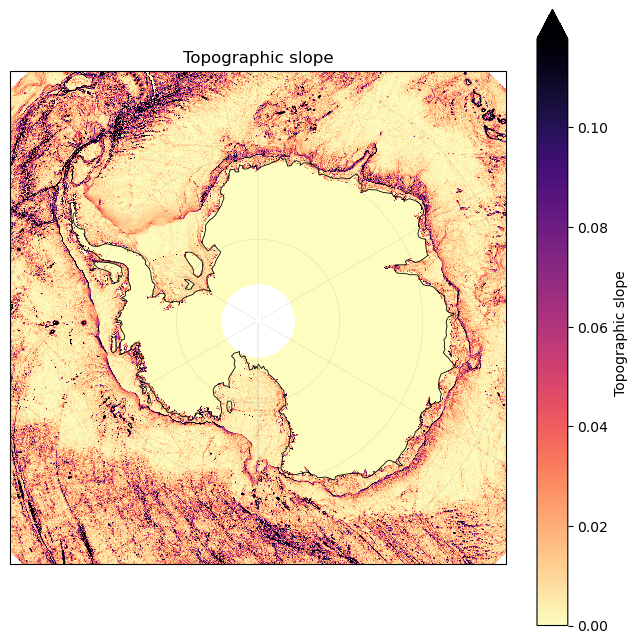

In [10]:
# Plot topographic slope

# 0) Get a 2-D (lat, lon) slice to plot
da = topo_slope
for d in ("date", "time", "depth", "lev"):
    if d in da.dims:
        da = da.isel({d: 0})
da = da.squeeze()  # drop size-1 dims if any

# 1) if lon runs 0..360 and includes 360 exactly, drop duplicate seam
if "lon" in da.coords:
    try:
        if np.isclose(float(da.lon[-1]) - float(da.lon[0]), 360.0):
            da = da.isel(lon=slice(0, -1))
    except Exception:
        pass

# make sure slope is non-negative
da = da.clip(min=0)

# 2) plot on polar stereographic
proj_data = ccrs.PlateCarree()
proj_map  = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj_map)

# extent: use this field's lon range and Antarctic lats
lon_min = float(da.lon.min())
lon_max = float(da.lon.max())
ax.set_extent([lon_min, lon_max, -90, -60], crs=proj_data)

# sequential limits (robust upper bound)
vmax = float(np.nanpercentile(da.values, 99))
vmax = max(vmax, 1e-6)  # avoid zero range
pcm = da.plot.pcolormesh(
    ax=ax,
    transform=proj_data,
    cmap="magma_r",           # yellow (low) → dark purple (high), matches your panel A vibe
    vmin=0, vmax=vmax,
    add_colorbar=True,
    add_labels=False,
    shading="auto",
    cbar_kwargs={"label": "Topographic slope"},
)

# optional map extras (same style)
try:
    ax.coastlines(resolution="110m", linewidth=0.6)
except Exception:
    pass

ax.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5)
ax.set_title("Topographic slope")

plt.show()

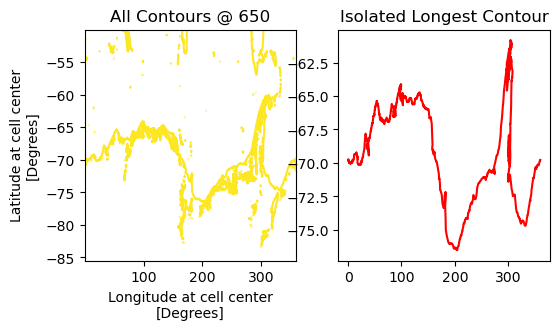

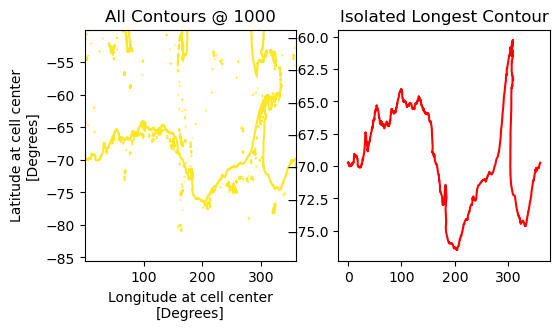

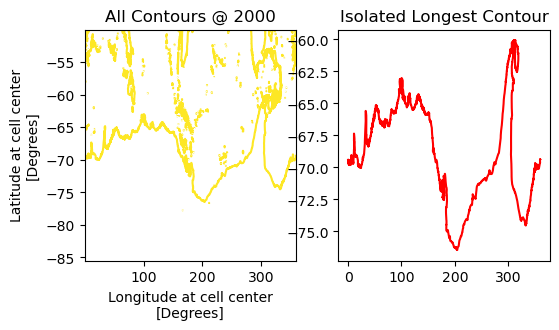

In [11]:
# Get coordinates of two circumpolar isobaths (650m and 2000m) using James Milward's "longest path" function 


def iso_contour(da, level, figsize=(6, 3), imshow=True):
    """
    Return the longest contour line (x,y) for a single contour level.
    Works with xarray's .plot.contour across Matplotlib/xarray versions.
    """
    # Two panels only if we want to visualize
    if imshow:
        fig, ax = plt.subplots(ncols=2, figsize=figsize)
        ax0, ax1 = ax
    else:
        fig, ax0 = plt.subplots(ncols=1, figsize=figsize)
        ax1 = None

    # Draw the contour (single level)
    cs = da.plot.contour(ax=ax0, levels=[level], add_colorbar=False)
    ax0.set_title(f"All Contours @ {level}")

    # Get all segments at this (single) level
    # cs.allsegs is a list of levels; each item is a list of (N_i,2) arrays
    seglists = cs.allsegs
    if not seglists or not seglists[0]:
        plt.close(fig)
        raise ValueError(f"No contour segments found at level {level}.")

    # Choose the longest segment by number of vertices
    longest = max(seglists[0], key=lambda seg: seg.shape[0])
    xaxis_coords, yaxis_coords = longest[:, 0], longest[:, 1]

    if ax1 is not None:
        ax1.plot(xaxis_coords, yaxis_coords, 'r-', lw=1.5)
        ax1.set_title("Isolated Longest Contour")

    if not imshow:
        plt.close(fig)

    return xaxis_coords, yaxis_coords

x650, y650   = iso_contour(bathym_on_uv, 650,  imshow=True)
x1000, y1000   = iso_contour(bathym_on_uv, 1000,  imshow=True)
x2000, y2000 = iso_contour(bathym_on_uv, 2000, imshow=True)

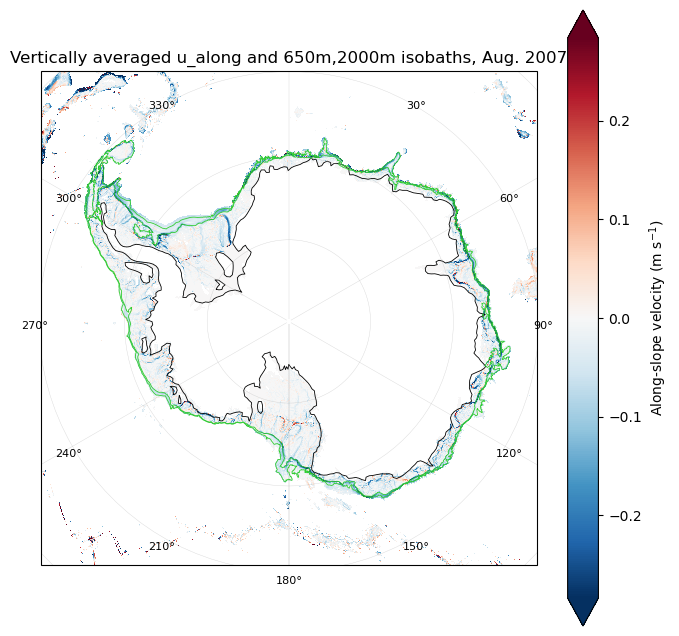

In [12]:
# Plot vertically averaged along-slope velocity and the 650m and 2000m circumpolar isobaths. 

## 0) Get a 2-D (lat, lon) slice to plot
da = u_along_0_500
for d in ("date", "time", "depth", "lev"):
    if d in da.dims:
        da = da.isel({d: 0})
da = da.squeeze()  # drop size-1 dims if any


# 1) if lon runs 0..360 and includes 360 exactly, drop duplicate seam
if "lon" in da.coords:
    try:
        if np.isclose(float(da.lon[-1]) - float(da.lon[0]), 360.0):
            da = da.isel(lon=slice(0, -1))
    except Exception:
        pass

# 2) plot on polar stereographic
proj_data = ccrs.PlateCarree()
proj_map  = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj_map)

# extent: use this field's lon range and Antarctic lats
lon_min = float(da.lon.min())
lon_max = float(da.lon.max())
ax.set_extent([lon_min, lon_max, -90, -60], crs=proj_data)

# symmetric color limits around 0 (robust)
vmax = float(np.nanpercentile(np.abs(da.values), 99))
vmax = max(vmax, 1e-6)  # avoid zero range
pcm = da.plot.pcolormesh(
    ax=ax,
    transform=proj_data,
    cmap="RdBu_r",
    vmin=-vmax, vmax=vmax,
    add_colorbar=True,
    add_labels=False,
    shading="auto",
    cbar_kwargs={"label": "Along-slope velocity (m s$^{-1}$)"},
)

# optional map extras (same style)
try:
    ax.coastlines(resolution="110m", linewidth=0.6)
except Exception:
    pass


# Plot longest circumpolar isobaths 
for x, y in [(x650, y650), (x2000, y2000)]:
    ax.plot(x, y, transform=proj_data, color="limegreen",
            linewidth=0.6, zorder=15)

# keep grid lines (no labels here)
ax.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5)

# --- longitude labels around boundary in 0..360 style ---
lon_ticks = np.arange(0, 360, 30)   # positions
label_lat = -59.5                   # just inside the -60° edge

for lam in lon_ticks:
    if lon_min <= lam <= lon_max:   # respect current extent (0..360)
        ax.text(lam, label_lat, f"{lam:.0f}°",
                transform=proj_data,
                ha="center", va="top", fontsize=8, clip_on=False)
        

ax.set_title('Vertically averaged u_along and 650m,2000m isobaths, Aug. 2007')    

plt.show()

In [14]:

# subset velocity field as a cross-slope slice between the two isobaths highlighted above. 

def _infer_xy_dims(da):
    # Try common names first; fall back to last two dims
    y_candidates = [d for d in da.dims if d.lower() in ("lat","y")]
    x_candidates = [d for d in da.dims if d.lower() in ("lon","x")]
    if not y_candidates or not x_candidates:
        # assume last two dims are (y, x)
        y_candidates = [da.dims[-2]]
        x_candidates = [da.dims[-1]]
    return y_candidates[0], x_candidates[0]

def _close_ring(x, y):
    if x[0] != x[-1] or y[0] != y[-1]:
        x = np.r_[x, x[0]]
        y = np.r_[y, y[0]]
    return x, y

def _polygon_area(x, y):
    # Shoelace (signed area). Useful to pick outer vs inner by area magnitude
    return 0.5 * np.sum(x[:-1]*y[1:] - x[1:]*y[:-1])

def mask_between_contours(x1, y1, x2, y2, grid_x, grid_y):
    """
    Return boolean mask of points that are inside the larger polygon
    and outside the smaller polygon (the band between contours).
    x*, y* are 1-D polyline vertices in same coords as grid_x/grid_y (lon/lat).
    grid_x, grid_y are 2-D arrays (mesh) of coordinates.
    """
    # Close both rings
    x1, y1 = _close_ring(np.asarray(x1), np.asarray(y1))
    x2, y2 = _close_ring(np.asarray(x2), np.asarray(y2))

    # Decide which is outer by absolute area
    a1 = abs(_polygon_area(x1, y1))
    a2 = abs(_polygon_area(x2, y2))
    if a1 >= a2:
        x_outer, y_outer = x1, y1
        x_inner, y_inner = x2, y2
    else:
        x_outer, y_outer = x2, y2
        x_inner, y_inner = x1, y1

    # Build Paths
    path_outer = Path(np.column_stack([x_outer, y_outer]))
    path_inner = Path(np.column_stack([x_inner, y_inner]))

    # Vectorized point-in-polygon on the grid
    pts = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    inside_outer = path_outer.contains_points(pts).reshape(grid_x.shape)
    inside_inner = path_inner.contains_points(pts).reshape(grid_x.shape)

    # Band between = inside outer AND NOT inside inner
    return inside_outer & ~inside_inner

# ---- Build grid from your bathymetry field ----
# Assumes bathym_on_uv has (lat, lon) coords (or similar).
y_dim, x_dim = _infer_xy_dims(bathym_on_uv)
yy = bathym_on_uv.coords[y_dim].values
xx = bathym_on_uv.coords[x_dim].values
XX, YY = np.meshgrid(xx, yy)  # shape = (lat, lon)

# ---- Make mask between the two isobath contours ----
band_mask_np = mask_between_contours(x650, y650, x2000, y2000, XX, YY)

# Wrap as DataArray with matching dims/coords
band_mask = xr.DataArray(
    band_mask_np,
    coords={y_dim: yy, x_dim: xx},
    dims=(y_dim, x_dim),
    name="between_650_2000_mask",
)



In [16]:
# ---- Apply to your velocity field (broadcasts over extra dims) ----
u_along_slice_0_500 = u_along_0_500.where(band_mask)
u_along_slice = u_along.where(band_mask)

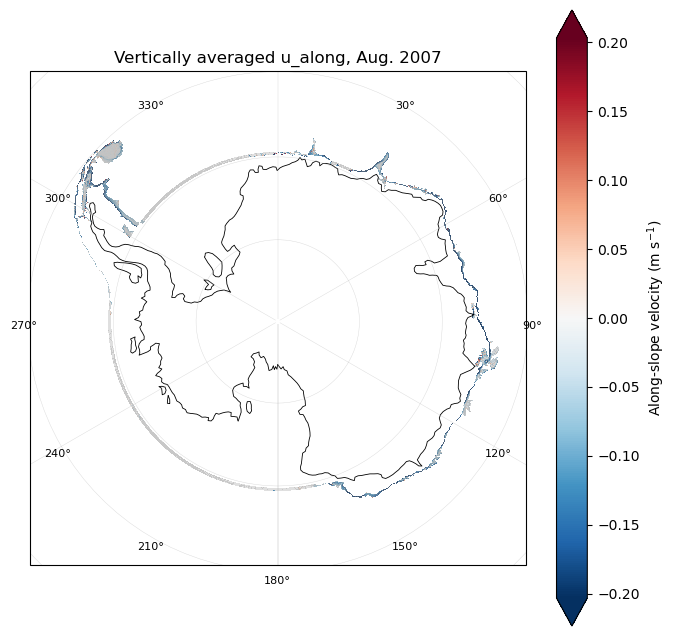

In [23]:
# replot velocity field between the two isobaths 

## 0) Get a 2-D (lat, lon) slice to plot
da = u_along_slice_0_500
for d in ("date", "time", "depth", "lev"):
    if d in da.dims:
        da = da.isel({d: 0})
da = da.squeeze()  # drop size-1 dims if any


# 1) if lon runs 0..360 and includes 360 exactly, drop duplicate seam
if "lon" in da.coords:
    try:
        if np.isclose(float(da.lon[-1]) - float(da.lon[0]), 360.0):
            da = da.isel(lon=slice(0, -1))
    except Exception:
        pass

# 2) plot on polar stereographic
proj_data = ccrs.PlateCarree()
proj_map  = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj_map)

# extent: use this field's lon range and Antarctic lats
lon_min = float(da.lon.min())
lon_max = float(da.lon.max())
ax.set_extent([lon_min, lon_max, -90, -60], crs=proj_data)

# symmetric color limits around 0 (robust)
vmax = float(np.nanpercentile(np.abs(da.values), 85))
vmax = max(vmax, 1e-6)  # avoid zero range
pcm = da.plot.pcolormesh(
    ax=ax,
    transform=proj_data,
    cmap="RdBu_r",
    vmin=-vmax, vmax=vmax,
    add_colorbar=True,
    add_labels=False,
    shading="auto",
    cbar_kwargs={"label": "Along-slope velocity (m s$^{-1}$)"},
)

# optional map extras (same style)
try:
    ax.coastlines(resolution="110m", linewidth=0.6)
except Exception:
    pass



# keep grid lines (no labels here)
ax.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5)

# --- longitude labels around boundary in 0..360 style ---
lon_ticks = np.arange(0, 360, 30)   # positions
label_lat = -59.5                   # just inside the -60° edge

for lam in lon_ticks:
    if lon_min <= lam <= lon_max:   # respect current extent (0..360)
        ax.text(lam, label_lat, f"{lam:.0f}°",
                transform=proj_data,
                ha="center", va="top", fontsize=8, clip_on=False)

# overlay band_mask shading (gray where True)
band_mask.where(band_mask).plot.pcolormesh(
    ax=ax,
    transform=proj_data,
    cmap="Greys",
    alpha=0.3,
    add_colorbar=False,
    add_labels=False,
    shading="auto",
)

ax.set_title('Vertically averaged u_along, Aug. 2007')    

plt.show()

In [26]:
# save output to netcdf 

os.chdir('/data/globus/zkaufman')

def save_da_nc(da: xr.DataArray, fname: str, *, var_name: str = None,
               compress: bool = True, engine: str = "netcdf4"):
    """
    Save a DataArray to NetCDF, preserving coords/attrs. Optionally compress.
    """
    # Ensure it has a variable name in the file
    if var_name is not None:
        da = da.rename(var_name)
    elif da.name is None:
        da = da.rename("variable")

    # Default encodings: zlib compression for variables (small + fast I/O)
    encoding = {}
    if compress:
        # compression for the data var
        encoding[da.name] = {"zlib": True, "complevel": 4}
        # lossless compression for coords, too (harmless; small win)
        for c in da.coords:
            encoding[c] = {"zlib": True, "complevel": 4}

    # Nice to have: write a creation timestamp in global attrs (non-destructive)
    ds = da.to_dataset()
    ds = ds.assign_attrs({
        **ds.attrs,
        "history": f"{datetime.utcnow().isoformat(timespec='seconds')}Z: wrote with xarray"
            + (f" (engine={engine})" if engine else "")
    })

    # If you have an unlimited dimension (e.g., time), set it here
    # unlimited = "time" if "time" in ds.dims else None
    ds.to_netcdf(
        fname,
        engine=engine,
        encoding=encoding,
        # unlimited_dims=unlimited,
    )
    print(f"Wrote {fname}")

# ---- Write your three arrays ----
# 1) u_along_0_500  (no depth dim; ensure a clear variable name)
save_da_nc(u_along_0_500, "u_along_0_500.nc", var_name="u_along", compress=True)

# 2) u_along (with depth dim)
save_da_nc(u_along, "u_along_fulldepth.nc", var_name="u_along", compress=True)

# 3) bathym_on_uv (positive depths)
save_da_nc(bathym_on_uv, "bathym_on_uv.nc", var_name="bathymetry", compress=True)

/tmp/ipykernel_876774/762569599.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "history": f"{datetime.utcnow().isoformat(timespec='seconds')}Z: wrote with xarray"


Wrote u_along_0_500.nc
Wrote u_along_fulldepth.nc
Wrote bathym_on_uv.nc


In [ ]:
# isolate user selected cross slope transects 

# --- helpers -------------------------------------------------------------
def infer_xy_dims(da):
    y_candidates = [d for d in da.dims if d.lower() in ("lat","latitude","y")]
    x_candidates = [d for d in da.dims if d.lower() in ("lon","longitude","x")]
    y_dim = y_candidates[0] if y_candidates else da.dims[-2]
    x_dim = x_candidates[0] if x_candidates else da.dims[-1]
    return y_dim, x_dim

def infer_depth_dim(da):
    for d in da.dims:
        dl = d.lower()
        if dl in ("depth","z","lev","level"):
            return d
    raise ValueError("Could not find a depth/z dimension in the DataArray.")

def drop_size1(da):
    # Drop/iseI any singleton dims except the core (lat,lon,depth)
    y_dim, x_dim = infer_xy_dims(da)
    z_dim = infer_depth_dim(da)
    for d in list(da.dims):
        if d not in (y_dim, x_dim, z_dim) and da.sizes[d] == 1:
            da = da.isel({d: 0}).drop(d)
    return da

# --- 1) Select the longitude transect -----------------------------------
y_dim, x_dim = infer_xy_dims(u_along)
z_dim = infer_depth_dim(u_along)

# ensure clean dims
u_clean = drop_size1(u_along)

# Pick lon = 120.0 (degrees). Adjust "method" as you prefer.
lon_target = 120.0
u_tr = u_clean.sel({x_dim: lon_target}, method="nearest")

# u_tr now has dims (depth, lat) in some order; reorder to (lat, depth)
if u_tr.dims != (y_dim, z_dim):
    u_tr = u_tr.transpose(y_dim, z_dim)

# --- 2) Subset to 0 to -2000 m ------------------------------------------
# Depth is negative downward in u_along (0 at surface, ~-5000 bottom)
depth_vals = u_tr.coords[z_dim].values
# Handle either increasing or decreasing coordinate
if depth_vals[0] > depth_vals[-1]:
    # likely decreasing (0, -..., -2000)
    u_tr2000 = u_tr.sel({z_dim: slice(0, -2000)})
else:
    # increasing (e.g., -5000 -> 0)
    u_tr2000 = u_tr.sel({z_dim: slice(-2000, 0)})

# --- 3) Build solid-earth mask from bathymetry along the transect -------
# bathym_on_uv is positive (meters). Get 1D bathy at the same longitude.
bathy_tr = bathym_on_uv.sel({x_dim: lon_target}, method="nearest")

# Align bathy lat dimension and broadcast to 2D (lat, depth)
bathy_tr = bathy_tr.rename({y_dim: y_dim})  # no-op but explicit
# Convert to negative depths (zbot is the seafloor depth in same sign as u)
zbot = -bathy_tr

# Broadcast to the section’s shape
Zbot2d, Depth2d = xr.broadcast(zbot, u_tr2000.isel({y_dim: 0})*0 + u_tr2000.coords[z_dim])
# Depth2d uses the section depth coordinate; we want array of same dims as u_tr2000
Depth2d = Depth2d.transpose(y_dim, z_dim)

# Solid earth is where depth is deeper (more negative) than bottom
solid_mask = (Depth2d < Zbot2d)


# --- 4) Plot: water (colored) + solid earth (gray overlay) --------------
fig, ax = plt.subplots(figsize=(9, 4.5))

# Contour/filled-contour of velocity
# choose levels or let matplotlib pick; add a colorbar
cf = ax.contourf(
    u_tr2000.coords[y_dim].values,    # latitude (x-axis)
    u_tr2000.coords[z_dim].values,    # depth (y-axis, negative)
    u_tr2000.transpose(y_dim, z_dim).values,
    levels=21
)
cb = fig.colorbar(cf, ax=ax, label="u (m/s)")

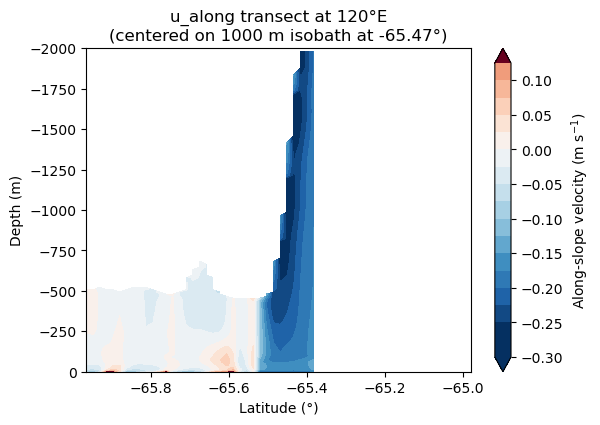

In [29]:
# --- parameters ---
lon_target = 120.0          # degrees (your grid is 0..360)
band_deg   = 1.0            # ~1°-wide latitude band

# --- 1) locate the first 1000 m isobath from the south along lon=120° ---
bcol = bathym_on_uv.sel(lon=lon_target, method="nearest").sortby("lat")
blat = bcol["lat"].values
bval = bcol.values

# keep finite values only
m = np.isfinite(bval)
blat, bval = blat[m], bval[m]

# find first crossing of 1000 m as we go northward
cross = np.where(np.sign(bval[:-1] - 1000) != np.sign(bval[1:] - 1000))[0]
if cross.size > 0:
    idx0 = cross[0] + 1
else:
    # fallback: closest to 1000 m
    idx0 = int(np.nanargmin(np.abs(bval - 1000)))

lat0 = float(blat[idx0])
lat_lo = lat0 - band_deg/2
lat_hi = lat0 + band_deg/2

# --- 2) extract u_along slice at lon≈120° within ~1° latitude band ---
# robust 1° band around the 1000 m isobath latitude (works for any lat ordering)
uda_lon = u_along.sel(lon=lon_target, method="nearest")
for d in ("date", "time", "lev"):
    if d in uda_lon.dims:
        uda_lon = uda_lon.isel({d: 0})

latmask = np.abs(uda_lon["lat"] - lat0) <= band_deg/2
uda_band = uda_lon.where(latmask, drop=True)

# --- 3) plot depth–latitude transect (0–2000 m, surface on top) ---
fig, ax = plt.subplots(figsize=(6.2, 4.2))

U = uda_band.transpose("depth", "lat")
# keep 0 to -2000 m regardless of coord ordering
dmask = (U["depth"] <= 0) & (U["depth"] >= -2000)
U = U.where(dmask, drop=True)

# mask continent (NaN or 0); set NaN color to grey
Uplot = U.where(U.notnull() & (U != 0))
import matplotlib.cm as cm
#cmap = cm.get_cmap("RdBu_r").copy()
#cmap.set_bad("0.7")  # grey for masked/land

vmax = float(np.nanpercentile(np.abs(Uplot.values), 99))
vmax = max(vmax, 1e-6)

pcm = ax.contourf(
    Uplot["lat"].values, Uplot["depth"].values, Uplot.values,
    levels=21, cmap="RdBu_r", vmin=-vmax, vmax=vmax, extend="both"
)
fig.colorbar(pcm, ax=ax, label="Along-slope velocity (m s$^{-1}$)")

ax.set_xlabel("Latitude (°)")
ax.set_ylabel("Depth (m)")
ax.set_title(f"u_along transect at {lon_target:.0f}°E\n(centered on 1000 m isobath at {lat0:.2f}°)")

# surface on top
ax.set_ylim(0, -2000)

plt.show()


In [25]:
U

<xarray.DataArray 'u_along' (depth: 0, lat: 58)> Size: 0B
array([], shape=(0, 58), dtype=float32)
Coordinates:
    date     float32 4B 1.356e+06
    lon      float32 4B 120.0
  * lat      (lat) float32 232B -65.96 -65.95 -65.93 ... -65.01 -65.0 -64.98
  * depth    (depth) float32 0B 
Attributes:
    long_name:  along-slope velocity (tangent to isobaths, +90° rot of ∇h)
    units:      m s-1
    notes:      Computed with spherical metrics from lon/lat; masked where |∇...